# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set(style="whitegrid")

# Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Check for Missing Values

In [3]:
print(train.info())
print(train.isnull().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int6

# Fill Missing Values

In [6]:
train.fillna(train.median(numeric_only=True), inplace=True)  # numeric columns
train.fillna(train.mode().iloc[0], inplace=True)  # categorical columns

# Basic EDA

## Survival Rate

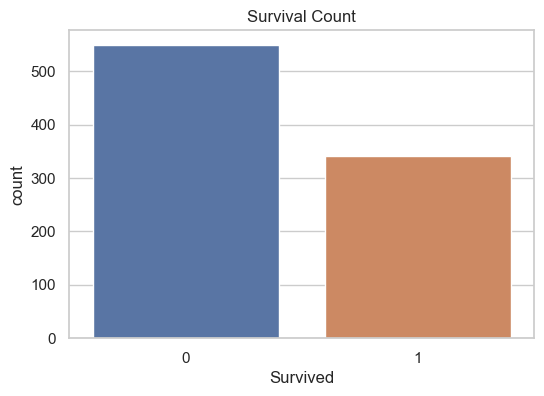

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title('Survival Count')
plt.show()

## Survival by Sex

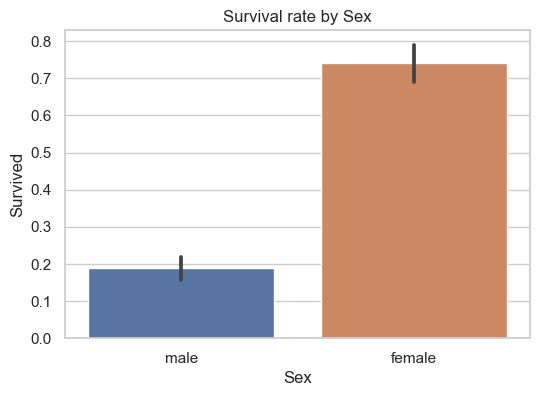

In [8]:
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival rate by Sex')
plt.show()

## Age Distribution

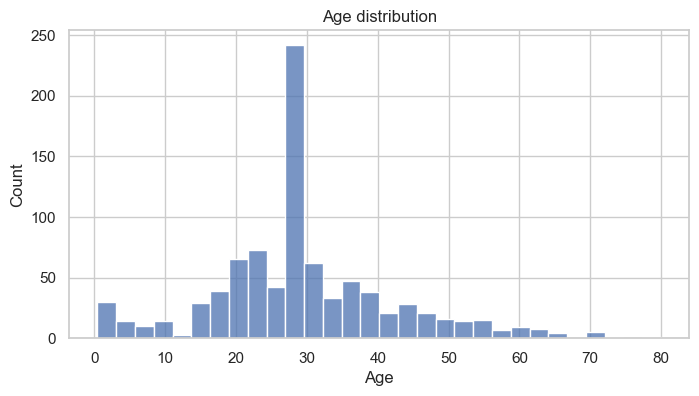

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(train['Age'].dropna(), bins=30, kde=False)
plt.title('Age distribution')
plt.show()

# Feature Engineering Helpers

In [10]:
def extract_title(name):
    # Extract title from name
    if pd.isna(name):
        return "Unknown"
    title = name.split(',')[1].split('.')[0].strip()
    return title

def preprocess(df):
    # Create copies to avoid modifying original
    df = df.copy()
    # Feature: FamilySize
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    # Title from name
    df['Title'] = df['Name'].apply(extract_title)
    # Reduce rare titles
    rare_titles = ['Lady', 'Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss')
    df['Title'] = df['Title'].replace('Mme','Mrs')
    # Cabin: replace with deck (first letter), missing -> 'U'
    df['CabinDeck'] = df['Cabin'].fillna('U').astype(str).str[0]
    # Ticket number prefix (optional): keep whether ticket is numeric
    df['TicketNumeric'] = df['Ticket'].str.isnumeric().astype(int)
    return df

# Apply to both
train_p = preprocess(train)
test_p  = preprocess(test)

# Combine train+test for consistent preprocessing
test_p['Survived'] = np.nan
combined = pd.concat([train_p, test_p], sort=False).reset_index(drop=True)
print("Combined shape:", combined.shape)

Combined shape: (1309, 17)


# Missing Values Handling & Final Feature List

In [11]:
# Impute Age by median per Title (better than global median)
combined['Age'] = combined.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# If still missing, fill with global median
combined['Age'].fillna(combined['Age'].median(), inplace=True)

# Fare: in test there may be missing fares (some datasets) -> fill by median of Pclass
combined['Fare'] = combined.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
combined['Fare'].fillna(combined['Fare'].median(), inplace=True)

# Embarked: fill with mode
combined['Embarked'].fillna(combined['Embarked'].mode()[0], inplace=True)

# Drop PassengerId only at modeling time; keep it for final submission
# Drop columns we won't use: Name, Ticket, Cabin (we used CabinDeck already), Cabin original
combined.drop(columns=['Name','Ticket','Cabin'], inplace=True, errors='ignore')

# Final feature selection (you can tweak)
features = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
    'FamilySize', 'IsAlone', 'Title', 'CabinDeck', 'TicketNumeric'
]

# Check missing values now
print("Missing counts after imputation:\n", combined[features].isnull().sum())

Missing counts after imputation:
 Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
CabinDeck        0
TicketNumeric    0
dtype: int64


# Encoding Categorical Features

In [12]:
# We'll one-hot encode: Sex, Embarked, Title, CabinDeck
cat_cols = ['Sex','Embarked','Title','CabinDeck']
num_cols = ['Pclass','Age','SibSp','Parch','Fare','FamilySize','IsAlone','TicketNumeric']

# Split combined back to train / test
train_proc = combined[combined['Survived'].notna()].copy()
test_proc  = combined[combined['Survived'].isna()].copy()

# Convert Survived to int
train_proc['Survived'] = train_proc['Survived'].astype(int)

X = train_proc[features].copy()
y = train_proc['Survived'].copy()
X_test_final = test_proc[features].copy()
test_passenger_ids = test_proc['PassengerId'].copy()

# One-hot via pandas (simple)
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X_test_final = pd.get_dummies(X_test_final, columns=cat_cols, drop_first=True)

# Ensure train and test have same columns
X, X_test_final = X.align(X_test_final, join='left', axis=1, fill_value=0)

print("Feature matrix shape (train):", X.shape)
print("Feature matrix shape (test):", X_test_final.shape)

Feature matrix shape (train): (891, 23)
Feature matrix shape (test): (418, 23)


# Train / Validation Split & Baseline Models

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)
print("Logistic Regression val accuracy:", accuracy_score(y_val, lr_preds))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
print("Random Forest val accuracy:", accuracy_score(y_val, rf_preds))

# Cross-validated scores
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_score = cross_val_score(rf, X, y, cv=cv, scoring='accuracy').mean()
lr_cv_score = cross_val_score(lr, X, y, cv=cv, scoring='accuracy').mean()
print(f"CV Accuracy — RandomForest: {rf_cv_score:.4f}, LogisticRegression: {lr_cv_score:.4f}")

# Feature importance (RF)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top features:\n", importances.head(10))

Logistic Regression val accuracy: 0.8268156424581006
Random Forest val accuracy: 0.8044692737430168
CV Accuracy — RandomForest: 0.8125, LogisticRegression: 0.8260
Top features:
 Fare           0.204575
Age            0.196605
Title_Mr       0.118759
Sex_male       0.111650
Pclass         0.062447
FamilySize     0.045056
Title_Mrs      0.041340
Title_Miss     0.035430
CabinDeck_B    0.030346
SibSp          0.027083
dtype: float64
